In [709]:
import json
import torch
import random
import matplotlib
from torch.utils.data import Dataset

print(torch.version.cuda)
print(torch.cuda.is_available())

12.4
True


In [748]:
import os

# Load utterances data
with open("../data_utterances/utt_model_data.json", "r") as f:
    full_data = json.load(f)

print(len(full_data))

# Load dialogue utterances
dialogue_folder = "../data_dialogues/BIO"
dialogue_utts = []
for fname in os.listdir(dialogue_folder):
    path = os.path.join(dialogue_folder, fname)
    with open(path, "r") as f:
        dialogue = json.load(f)

    for utt in dialogue["utterances"]:
        dialogue_utts.append({
            "utterance_id": utt["utt_id"],
            "tokens": utt["tokens"],
            "labels": utt["tags"],
        })

# Combine
full_data.extend(dialogue_utts)
print(f"Total examples after merge: {len(full_data)}")

random.seed(42)
random.shuffle(full_data)

split_ratio = 0.9
split_idx   = int(len(full_data) * split_ratio)
train_data  = full_data[:split_idx]
test_data   = full_data[split_idx:]

os.makedirs("../data_utterances", exist_ok=True)
with open("../data_utterances/train.json", "w") as f:
    json.dump(train_data, f, indent=2)

with open("../data_utterances/test.json", "w") as f:
    json.dump(test_data, f, indent=2)

print(f"Split: {len(train_data)} train / {len(test_data)} test.")

160
Total examples after merge: 367
Split: 330 train / 37 test.


In [711]:
with open("../data_utterances/train.json") as f:
    train_data = json.load(f)

with open("../data_utterances/test.json") as f:
    test_data = json.load(f)

In [712]:
# Build vocab and labels 
labels = set()
intents = set()

for message in train_data:
    labels.update(message["labels"])

label2id = {label: idx for idx, label in enumerate(sorted(labels))}

# Build vocabulary
vocab = {"<PAD>": 0, "<UNK>": 1}
for example in train_data:
    for token in example["tokens"]:
        token = token.lower()
        if token not in vocab:
            vocab[token] = len(vocab)

print(f"Vocab size: {len(vocab)}")
print(f"Labels: {sorted(label2id.keys())}")
print(f"Number of labels: {len(labels)}")


Vocab size: 526
Labels: ['B-ALTITUDE', 'B-APPROACH', 'B-CALLSIGN', 'B-CLEARANCE', 'B-CONDITION', 'B-FACILITY', 'B-FREQUENCY', 'B-HEADING', 'B-INSTRUCTION', 'B-REQUEST', 'B-ROUTE', 'B-RUNWAY', 'B-SPEED', 'B-SQUAWK', 'B-STATUS', 'B-TAXIWAY', 'B-TEMPORAL_MODIFIER', 'B-TRAFFIC', 'B-TRIGGER', 'B-WAYPOINT', 'B-WIND', 'I-ALTITUDE', 'I-APPROACH', 'I-CALLSIGN', 'I-CLEARANCE', 'I-CONDITION', 'I-FACILITY', 'I-FREQUENCY', 'I-HEADING', 'I-INSTRUCTION', 'I-REQUEST', 'I-ROUTE', 'I-RUNWAY', 'I-SPEED', 'I-SQUAWK', 'I-STATUS', 'I-TAXIWAY', 'I-TRAFFIC', 'I-TRIGGER', 'I-WAYPOINT', 'I-WIND', 'O']
Number of labels: 42


In [713]:
class ATCDataset(Dataset):
    def __init__(self, data, vocab, label2id, max_len=50):
        self.data = data
        self.vocab = vocab
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = item["tokens"]
        labels = item["labels"]

        input_ids = [self.vocab.get(token.lower(), self.vocab["<UNK>"]) for token in tokens]
        label_ids = [self.label2id[label] for label in labels]

        pad_len = self.max_len - len(input_ids)
        if pad_len > 0:
            input_ids += [self.vocab["<PAD>"]] * pad_len
            label_ids += [self.label2id["O"]] * pad_len
        else:
            input_ids = input_ids[:self.max_len]
            label_ids = label_ids[:self.max_len]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(label_ids, dtype=torch.long),
            "length": torch.tensor(min(len(tokens), self.max_len), dtype=torch.long)
        }

In [714]:
dataset = ATCDataset(train_data, vocab, label2id)
print("Sample from dataset:")
sample = dataset[0]
print(sample)

Sample from dataset:
{'input_ids': tensor([ 2,  3,  4,  5,  6,  7,  4,  8,  9, 10, 11, 12,  4,  4,  5, 13, 14,  4,
        15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), 'labels': tensor([41,  2, 23, 23, 23, 11, 32, 32,  3, 24, 24, 20, 40, 40, 40, 40, 40, 40,
        40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
        41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]), 'length': tensor(19)}


In [715]:
# This is just a test, taking the sample from above and reversing the token to produce words
id2word = {idx: word for word, idx in vocab.items()}
tokens = [id2word[i.item()] for i in sample['input_ids'] if i.item() != vocab["<PAD>"]]
print(tokens)

['uwb-atcc_twr-7sxor3_000114_000686_at:', 'donavia', 'three', 'zero', 'five', 'runway', 'three', 'one', 'clear', 'to', 'land', 'wind', 'three', 'three', 'zero', 'degrees', 'and', 'three', 'knots']


In [716]:
# ... same for labels
id2label = {idx: label for label, idx in label2id.items()}
slot_labels = [id2label[i.item()] for i in sample['labels'][:sample['length']]]
print(slot_labels)

['O', 'B-CALLSIGN', 'I-CALLSIGN', 'I-CALLSIGN', 'I-CALLSIGN', 'B-RUNWAY', 'I-RUNWAY', 'I-RUNWAY', 'B-CLEARANCE', 'I-CLEARANCE', 'I-CLEARANCE', 'B-WIND', 'I-WIND', 'I-WIND', 'I-WIND', 'I-WIND', 'I-WIND', 'I-WIND', 'I-WIND']


In [717]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, pad_idx):
        super(LSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.slot_classifier = nn.Linear(hidden_dim * 2, num_labels)
        
    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)

        packed_input = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input)
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)

        slot_logits = self.slot_classifier(lstm_out)
        
        forward_final = hn[0]
        backward_final = hn[1]

        final_hidden = torch.cat([forward_final, backward_final], dim=-1)

        return slot_logits

In [718]:
from torch.utils.data import DataLoader

train_dataset = ATCDataset(
    data=train_data,
    vocab=vocab,
    label2id=label2id,
    max_len=50
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)

test_dataset = ATCDataset(
    data=test_data,
    vocab=vocab,
    label2id=label2id,
    max_len=50
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

In [719]:
pad_label_id = label2id["O"]

# Loss functions
slot_loss_fn = nn.CrossEntropyLoss(ignore_index=pad_label_id)

def train(model, dataloader, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            lengths = batch["length"].cpu()

            optimizer.zero_grad()
            slot_logits = model(input_ids, lengths)

            max_len = slot_logits.size(1)
            labels = labels[:, :max_len]

            slot_logits_flat = slot_logits.reshape(-1, slot_logits.size(-1))
            labels_flat = labels.reshape(-1)

            slot_loss = slot_loss_fn(slot_logits_flat, labels_flat)
            loss = slot_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return epoch_losses

In [736]:
model = LSTM(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=128,
    num_labels=len(label2id),
    pad_idx=vocab["<PAD>"]
)

params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {params:,}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
losses = train(model, train_loader, num_epochs=12, learning_rate=0.005, device=device)

Parameters: 298,914
Training on cuda
Epoch 1/12, Loss: 2.3232
Epoch 2/12, Loss: 0.9468
Epoch 3/12, Loss: 0.4803
Epoch 4/12, Loss: 0.2337
Epoch 5/12, Loss: 0.1382
Epoch 6/12, Loss: 0.0842
Epoch 7/12, Loss: 0.0590
Epoch 8/12, Loss: 0.0404
Epoch 9/12, Loss: 0.0467
Epoch 10/12, Loss: 0.0256
Epoch 11/12, Loss: 0.0235
Epoch 12/12, Loss: 0.0165


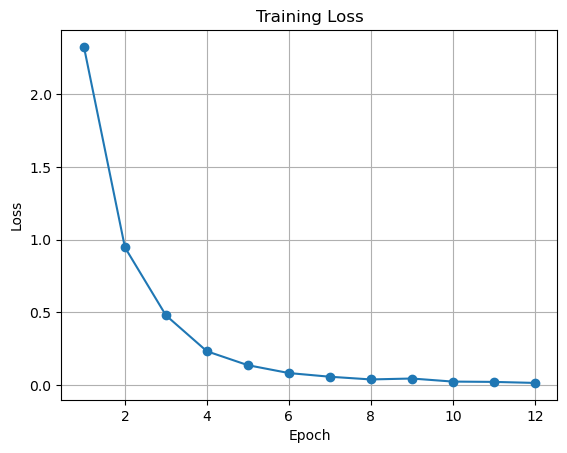

In [737]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [738]:
from sklearn.metrics import classification_report

def evaluate(model, dataloader, label2id, device="cpu"):
    model.eval()
    all_true_slots = []
    all_pred_slots = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            lengths = batch["length"].cpu()

            slot_logits = model(input_ids, lengths)

            slot_preds = slot_logits.argmax(dim=-1)

            for i in range(len(lengths)):
                true_len = lengths[i].item()
                all_true_slots.extend(labels[i][:true_len].cpu().tolist())
                all_pred_slots.extend(slot_preds[i][:true_len].cpu().tolist())

    print("Slot Report:")
    print(classification_report(
        all_true_slots,
        all_pred_slots,
        labels=list(label2id.values()),
        target_names=list(label2id.keys()),
        zero_division=0
    ))

In [739]:
evaluate(model, test_loader, label2id, device=device)

Slot Report:
                     precision    recall  f1-score   support

         B-ALTITUDE       0.78      0.88      0.82         8
         B-APPROACH       0.50      1.00      0.67         2
         B-CALLSIGN       0.71      0.85      0.77        34
        B-CLEARANCE       0.89      1.00      0.94         8
        B-CONDITION       0.75      0.60      0.67         5
         B-FACILITY       0.60      1.00      0.75         6
        B-FREQUENCY       1.00      1.00      1.00         3
          B-HEADING       0.83      1.00      0.91         5
      B-INSTRUCTION       0.81      0.93      0.86        27
          B-REQUEST       1.00      1.00      1.00         1
            B-ROUTE       1.00      1.00      1.00         1
           B-RUNWAY       1.00      0.67      0.80         9
            B-SPEED       0.50      0.33      0.40         3
           B-SQUAWK       0.00      0.00      0.00         0
           B-STATUS       0.00      0.00      0.00         0
          

In [740]:
import torch.nn.functional as Func

def predict(model, sentence, vocab, label2id, max_len=50, device="cpu"):
    model.eval()
    id2label = {v: k for k, v in label2id.items()}

    tokens = sentence.lower().split()
    input_ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]

    if len(input_ids) < max_len:
        input_ids += [vocab["<PAD>"]] * (max_len - len(input_ids))
    else:
        input_ids = input_ids[:max_len]

    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    lengths = torch.tensor([min(len(tokens), max_len)], dtype=torch.long).to('cpu')

    with torch.no_grad():
        slot_logits = model(input_tensor, lengths)
        slot_probs = Func.softmax(slot_logits, dim=-1)
        slot_preds = slot_probs.argmax(dim=-1).squeeze(0).tolist()
        slot_confidences = slot_probs.squeeze(0).max(dim=-1).values.tolist()

    print("Input:", sentence)
    for token, label_id, conf in zip(tokens, slot_preds[:len(tokens)], slot_confidences[:len(tokens)]):
        label = id2label[label_id]
        print(f"  {token:10} → {label:15} ({conf * 100:.1f}%)")

In [741]:
predict(
    model,
    sentence="skywest four five two cleared to land runway three two right",
    vocab=vocab,
    label2id=label2id,
    device=device
)

Input: skywest four five two cleared to land runway three two right
  skywest    → I-CALLSIGN      (69.9%)
  four       → I-CALLSIGN      (98.4%)
  five       → I-CALLSIGN      (99.6%)
  two        → I-CALLSIGN      (99.5%)
  cleared    → B-CLEARANCE     (99.9%)
  to         → I-CLEARANCE     (99.8%)
  land       → I-CLEARANCE     (99.9%)
  runway     → B-RUNWAY        (99.9%)
  three      → I-RUNWAY        (99.6%)
  two        → I-RUNWAY        (99.9%)
  right      → I-RUNWAY        (99.7%)


In [742]:
predict(
    model,
    sentence="sky four two three turn right heading three zero zero",
    vocab=vocab,
    label2id=label2id,
    device=device
)

Input: sky four two three turn right heading three zero zero
  sky        → B-CALLSIGN      (86.5%)
  four       → I-CALLSIGN      (98.4%)
  two        → I-CALLSIGN      (98.8%)
  three      → I-CALLSIGN      (92.6%)
  turn       → B-INSTRUCTION   (99.6%)
  right      → I-INSTRUCTION   (99.9%)
  heading    → B-HEADING       (99.7%)
  three      → I-HEADING       (94.0%)
  zero       → I-HEADING       (99.9%)
  zero       → I-HEADING       (99.9%)


In [743]:
predict(
    model,
    sentence="delta one two three cleared direct chino then maintain five thousand",
    vocab=vocab,
    label2id=label2id,
    device=device
)

Input: delta one two three cleared direct chino then maintain five thousand
  delta      → B-CALLSIGN      (99.9%)
  one        → I-CALLSIGN      (99.9%)
  two        → I-CALLSIGN      (100.0%)
  three      → I-CALLSIGN      (100.0%)
  cleared    → B-CLEARANCE     (93.8%)
  direct     → B-INSTRUCTION   (71.2%)
  chino      → B-WAYPOINT      (94.8%)
  then       → B-TEMPORAL_MODIFIER (99.1%)
  maintain   → I-INSTRUCTION   (69.9%)
  five       → I-TRAFFIC       (44.5%)
  thousand   → I-CALLSIGN      (35.9%)


In [744]:
predict(
    model,
    sentence="southwest five five two runway three two right clear for takeoff winds zero five zero at nine",
    vocab=vocab,
    label2id=label2id,
    device=device
)

Input: southwest five five two runway three two right clear for takeoff winds zero five zero at nine
  southwest  → B-CALLSIGN      (99.8%)
  five       → I-CALLSIGN      (99.9%)
  five       → I-CALLSIGN      (100.0%)
  two        → I-CALLSIGN      (100.0%)
  runway     → B-RUNWAY        (99.2%)
  three      → I-RUNWAY        (99.6%)
  two        → I-RUNWAY        (99.9%)
  right      → I-RUNWAY        (99.2%)
  clear      → B-CLEARANCE     (99.6%)
  for        → I-CLEARANCE     (98.8%)
  takeoff    → I-CLEARANCE     (96.1%)
  winds      → B-WIND          (94.4%)
  zero       → I-WIND          (95.5%)
  five       → I-WIND          (93.2%)
  zero       → I-WIND          (90.9%)
  at         → I-WIND          (86.2%)
  nine       → I-WIND          (58.2%)


In [745]:
predict(
    model,
    sentence="five thousand for delta one two one",
    vocab=vocab,
    label2id=label2id,
    device=device
)

Input: five thousand for delta one two one
  five       → B-ALTITUDE      (44.5%)
  thousand   → I-ALTITUDE      (85.1%)
  for        → B-STATUS        (90.4%)
  delta      → B-CALLSIGN      (99.6%)
  one        → I-CALLSIGN      (98.2%)
  two        → I-CALLSIGN      (100.0%)
  one        → I-CALLSIGN      (99.9%)


In [746]:
from pathlib import Path

# Save weights to .pt file
SAVE_DIR = "../app/models/utterance_lstm"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
SAVE_PATH = f"{SAVE_DIR}/slot_lstm.pt"

hidden_size   = model.lstm.hidden_size
num_labels  = len(labels)

checkpoint = {
    "state_dict": model.state_dict(),
    "config": {
        "vocab_size"   : model.embedding.num_embeddings,
        "embedding_dim": model.embedding.embedding_dim,
        "hidden_size"  : hidden_size,
        "num_labels"   : num_labels,
        "label_list"   : labels
    }
}
torch.save(checkpoint, SAVE_PATH)
print(f"Weights saved to {SAVE_PATH}")

Weights saved to ../app/models/utterance_lstm/slot_lstm.pt


In [747]:
id2label = {v: k for k, v in label2id.items()}

# Save vocab
with open("../app/models/utterance_lstm/vocab.json", "w") as f:
    json.dump(vocab, f)
with open("../app/models/utterance_lstm/label2id.json", "w") as f:
    json.dump(label2id, f)
with open("../app/models/utterance_lstm/id2label.json", "w") as f:
    json.dump(id2label, f)

print("saved!")

saved!
